# Assignment

In [6]:
# Import 

import numpy as np
import matplotlib.pyplot as plt
from degree_freedom_queen import *
from degree_freedom_king1 import *
from degree_freedom_king2 import *
from generate_game import *
from Chess_env import *
import numpy.matlib 


size_board = 4

## The Environment

You can find the environment in the file Chess_env, which contains the class Chess_env. To define an object, you need to provide the board size considered as input. In our example, size_board=4. 
Chess_env is composed by the following methods:

1. Initialise_game. The method initialises an episode by placing the three pieces considered (Agent's king and queen, enemy's king) in the chess board. The outputs of the method are described below in order.

     S $\;$ A matrix representing the board locations filled with 4 numbers: 0, no piece in that position; 1, location of the 
     agent's king; 2 location of the queen; 3 location of the enemy king.
     
     X $\;$ The features, that is the input to the neural network. See the assignment for more information regarding the            definition of the features adopted. To personalise this, go into the Features method of the class Chess_env() and change        accordingly.
     
     allowed_a $\;$ The allowed actions that the agent can make. The agent is moving a king, with a total number of 8                possible actions, and a queen, with a total number of $(board_{size}-1)\times 8$ actions. The total number of possible actions correspond      to the sum of the two, but not all actions are allowed in a given position (movements to locations outside the borders or      against chess rules). Thus, the variable allowed_a is a vector that is one (zero) for an action that the agent can (can't)      make. Be careful, apply the policy considered on the actions that are allowed only.
     

2. OneStep. The method performs a one step update of the system. Given as input the action selected by the agent, it updates the chess board by performing that action and the response of the enemy king (which is a random allowed action in the settings considered). The first three outputs are the same as for the Initialise_game method, but the variables are computed for the position reached after the update of the system. The fourth and fifth outputs are:

     R $\;$ The reward. To change this, look at the OneStep method of the class where the rewards are set.
     
     Done $\;$ A variable that is 1 if the episode has ended (checkmate or draw).
     
     
3. Features. Given the chessboard position, the method computes the features.

This information and a quick analysis of the class should be all you need to get going. The other functions that the class exploits are uncommented and constitute an example on how not to write a python code. You can take a look at them if you want, but it is not necessary.






In [7]:
## INITIALISE THE ENVIRONMENT

env=Chess_Env(size_board)

# 0 (NO PIECE), 1 (AGENT'S KING), 2 (AGENT'S QUEEN), 3 (OPPONENT'S KING)

In [12]:
## PRINT 5 STEPS OF AN EPISODE CONSIDERING A RANDOM AGENT

S,X,allowed_a=env.Initialise_game()                       # INTIALISE GAME

print(S)                                                  # PRINT CHESS BOARD (SEE THE DESCRIPTION ABOVE)

print('check? ',env.check)                                # PRINT VARIABLE THAT TELLS IF ENEMY KING IS IN CHECK (1) OR NOT (0)
print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))    # PRINT THE NUMBER OF LOCATIONS THAT THE ENEMY KING CAN MOVE TO


for i in range(5):
    
    a,_=np.where(allowed_a==1)                  # FIND WHAT THE ALLOWED ACTIONS ARE
    a_agent=np.random.permutation(a)[0]         # MAKE A RANDOM ACTION

    S,X,allowed_a,R,Done=env.OneStep(a_agent)   # UPDATE THE ENVIRONMENT
    
    
    ## PRINT CHESS BOARD AND VARIABLES
    print('')
    print(S)
    print(R,'', Done)
    print('check? ',env.check)
    print('dofk2 ',np.sum(env.dfk2_constrain).astype(int))
    
    
    # TERMINATE THE EPISODE IF Done=True (DRAW OR CHECKMATE)
    if Done:
        break
        


[[3 0 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 1 0 0]]
check?  0
dofk2  1

[[0 3 0 0]
 [0 0 0 2]
 [0 0 0 0]
 [0 0 1 0]]
0  0
check?  0
dofk2  1

[[3 0 0 0]
 [0 0 0 2]
 [0 0 0 1]
 [0 0 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 0]
 [3 0 1 2]
 [0 0 0 0]
 [0 0 0 0]]
0  0
check?  0
dofk2  2

[[3 0 0 0]
 [0 0 1 0]
 [0 0 0 0]
 [0 2 0 0]]
0  0
check?  0
dofk2  1

[[0 0 0 1]
 [3 0 0 0]
 [0 0 0 0]
 [0 2 0 0]]
0  0
check?  0
dofk2  1


In [22]:
# PERFORM N_episodes=1000 EPISODES MAKING RANDOM ACTIONS AND COMPUTE THE AVERAGE REWARD AND NUMBER OF MOVES 

S,X,allowed_a=env.Initialise_game()
N_episodes=1000

# VARIABLES WHERE TO SAVE THE FINAL REWARD IN AN EPISODE AND THE NUMBER OF MOVES 
R_save_random = np.zeros([N_episodes, 1])
N_moves_save_random = np.zeros([N_episodes, 1])

for n in range(N_episodes):
    
    S,X,allowed_a=env.Initialise_game()     # INITIALISE GAME
    Done=0                                  # SET Done=0 AT THE BEGINNING
    i=1                                     # COUNTER FOR THE NUMBER OF ACTIONS (MOVES) IN AN EPISODE
    
    # UNTIL THE EPISODE IS NOT OVER...(Done=0)
    while Done==0:
        
        # SAME AS THE CELL BEFORE, BUT SAVING THE RESULTS WHEN THE EPISODE TERMINATES 
        
        a,_=np.where(allowed_a==1)
        a_agent=np.random.permutation(a)[0]

        S,X,allowed_a,R,Done=env.OneStep(a_agent)
        
        
        if Done:
            
            R_save_random[n]=np.copy(R)
            N_moves_save_random[n]=np.copy(i)

            break

        i=i+1                               # UPDATE THE COUNTER



# AS YOU SEE, THE PERFORMANCE OF A RANDOM AGENT ARE NOT GREAT, SINCE THE MAJORITY OF THE POSITIONS END WITH A DRAW 
# (THE ENEMY KING IS NOT IN CHECK AND CAN'T MOVE)

print('Random_Agent, Average reward:',np.mean(R_save_random),'Number of steps: ',np.mean(N_moves_save_random))



Random_Agent, Average reward: 0.211 Number of steps:  7.227


In [13]:
def Init_network():
    S,X,allowed_a=env.Initialise_game()
    N_a=np.shape(allowed_a)[0]   # TOTAL NUMBER OF POSSIBLE ACTIONS

    N_in=np.shape(X)[0]    ## INPUT SIZE
    N_h=200                ## NUMBER OF HIDDEN NODES


    ## INITALISE YOUR NEURAL NETWORK...

    # YOUR CODE HERE

    ## INITALISE YOUR NEURAL NETWORK...
    W1=np.random.randn(N_h,N_in) * np.sqrt(1/N_in)
    W2=np.random.randn(N_a, N_h) * np.sqrt(1/N_h)

                        
    bias_W1 = np.zeros((N_h,))

    bias_W2 = np.zeros((N_a,))
    return S, X, W1,W2,bias_W1,bias_W2

In [14]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

S, X, W1,W2,bias_W1,bias_W2=Init_network()



# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 10000 # THE NUMBER OF GAMES TO BE PLAYED 

# SAVING VARIABLES
R_save = np.zeros([N_episodes, 1])
N_moves_save = np.zeros([N_episodes, 1])


In [15]:
def forward_prop(state, W1, W2, bias_W1, bias_W2):
    
    h1 = np.dot(W1, state) + bias_W1
    x1 = (h1 > 0) * h1
    
    h2 = np.dot(W2, x1) + bias_W2
    x2 = (h2 > 0) * h2

#     output_layer_output = np.maximum(0, output_layer_input)
#     return output_layer_input
    return h1, x1, h2, x2


# write a function to get q values for all actions

print(forward_prop(X, W1, W2, bias_W1, bias_W2))

(array([ 1.06139133e-01,  2.48305032e-01, -3.23675486e-01,  5.73579534e-01,
        7.13287361e-01, -4.79329815e-01,  5.26624523e-02, -8.38934519e-02,
       -2.93154040e-01,  9.04860842e-02, -5.74110974e-02,  3.14541054e-01,
       -1.46767628e-01, -1.28946068e-01,  5.91119943e-01,  6.69786893e-01,
        2.69097617e-01,  3.51556814e-02, -6.74763792e-02, -5.25692338e-01,
       -2.29429928e-01,  2.09101547e-02, -1.24583424e-01, -5.25315440e-02,
        6.14907225e-02,  3.32086329e-01,  3.67572303e-01, -3.34771905e-02,
        2.13022975e-01, -5.81743249e-02,  2.14668830e-01, -3.39250236e-01,
       -1.01087771e-01,  1.77452119e-01, -1.63905040e-01, -3.93199111e-01,
        1.74202104e-01,  2.26596663e-01, -1.69282488e-01, -3.26737454e-01,
       -5.86877698e-02,  5.25761146e-02,  2.30834121e-01, -3.47355680e-01,
       -3.76461125e-01,  7.97739285e-02,  2.84776443e-01, -2.80292469e-01,
       -4.95751853e-02, -9.94368312e-03, -1.70990863e-02,  3.97822669e-01,
        5.92524040e-02, 

(array([-0.        ,  0.00401625,  0.08242222,  0.16482379, -0.        ,
       -0.        ,  0.0290335 , -0.        ,  0.12445674,  0.30098718,
        0.0133195 , -0.        , -0.        , -0.        , -0.        ,
       -0.        ,  0.19652301, -0.        , -0.        , -0.        ,
       -0.        , -0.        ,  0.09689709,  0.12393483,  0.04158038,
        0.03563231, -0.        ,  0.05229145,  0.05992875, -0.        ,
       -0.        ,  0.08643339]), array([-0.25903559,  0.00401625,  0.08242222,  0.16482379, -0.33540149,
       -0.20553224,  0.0290335 , -0.21283449,  0.12445674,  0.30098718,
        0.0133195 , -0.25312246, -0.32381598, -0.2928401 , -0.20804041,
       -0.05234068,  0.19652301, -0.06729241, -0.04879114, -0.49140103,
       -0.08407886, -0.08180709,  0.09689709,  0.12393483,  0.04158038,
        0.03563231, -0.21472499,  0.05229145,  0.05992875, -0.17508631,
       -0.09883533,  0.08643339]), array([-0.        ,  0.21472013, -0.        ,  0.03188774, -0.   

In [13]:
def backProp(state, output_in, hidden_out, hidden_in, W2, TD_error, Q_values, eta, gamma):
    
    dW2 = np.zeros(W2.shape)
    dW1 = np.zeros(W1.shape)
    dbias_W2 = np.zeros(bias_W2.shape)
    dbias_W1 = np.zeros(bias_W1.shape)
    
    dW2 = np.outer(TD_error, hidden_out)
    dbias_W2 = TD_error
    
    dhidden_out = np.dot(W2.T, TD_error)
    dhidden_in = dhidden_out * (hidden_in > 0)
    
    dW1 = np.outer(dhidden_in, state)
    dbias_W1 = dhidden_in
    
    return dW1, dW2, dbias_W1, dbias_W2

In [16]:
def EpsilonGreedy_Policy(qvalues, epsilon, allowed_actions):
    Qvalues = qvalues.reshape((32, 1))
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon
    
    if rand_a==True:
        
        allowed_indices = np.where(allowed_actions == 1)[0]
        a = np.random.choice(allowed_indices)
        
        
    else:
            allowed_indices = np.where(allowed_actions == 1)[0]
            allowed_Qvalues = Qvalues[allowed_indices]
            max_index = allowed_indices[np.argmax(allowed_Qvalues)]
            a = max_index
        
        
            
    return a

In [17]:
# TRAINING LOOP BONE STRUCTURE...
# I WROTE FOR YOU A RANDOM AGENT (THE RANDOM AGENT WILL BE SLOWER TO GIVE CHECKMATE THAN AN OPTIMISED ONE, 
# SO DON'T GET CONCERNED BY THE TIME IT TAKES), CHANGE WITH YOURS ...

q_learning = False


for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        h1, x1, h2, q_values = forward_prop(X, W1, W2, bias_W1, bias_W2)
        
        a_agent= EpsilonGreedy_Policy(q_values, epsilon_f, allowed_a)
        
        
                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)



        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            # write the weight updates for the last step of the episode
            
            target_q_values = q_values.copy()
            target_q_values[a_agent] = R 
            e_n = target_q_values - q_values
            dW2 = np.outer(e_n, x1)
            dbias_W2 = e_n
            dh = np.dot(W2.T, e_n)
            dh[h1 <= 0] = 0
            dW1 = np.outer(dh, X)
            dbias_W1 = dh
            


            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2

            R_save[n]=np.copy(R)
            N_moves_save[n]=np.copy(i)
            break
        
        
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            h1_next, x1_next, h2_next, q_values1 = forward_prop(X_next, W1, W2, bias_W1, bias_W2)
            if q_learning == True:
                # Q learning "greedy" policy
                a_agent1 = EpsilonGreedy_Policy(q_values1, 0, allowed_a)
            else:
                # SARSA policy
                a_agent1 = EpsilonGreedy_Policy(q_values1, epsilon_f, allowed_a)

            target_q_values = q_values.copy()
            target_q_values[a_agent] = R + gamma*q_values1[a_agent1]
            e_n = target_q_values - q_values
            
            dW2 = np.outer(e_n, x1)
            dbias_W2 = e_n
            dh = np.dot(W2.T, e_n)
            dh[h1 <= 0] = 0
            dW1 = np.outer(dh, X)
            dbias_W1 = dh
            
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2

            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)
            
            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
print(' Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

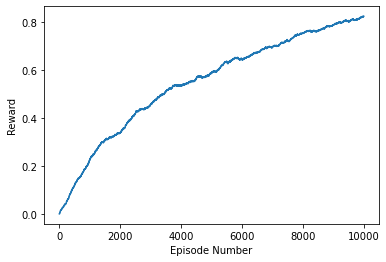

In [18]:
# fig=plt.subplots(1,1)
# plt.plot(np.sum(R_save,1))
# plt.xlabel('Episode Number')
# plt.ylabel('Reward')
# plt.show()


alpha = 0.001
ema = np.zeros_like(R_save)  # Initialize an array for EMA values
ema[0] = R_save[0]  # Set the initial EMA value equal to the first data point
for i in range(1, len(R_save)):
    ema[i] = alpha * R_save[i] + (1 - alpha) * ema[i-1]

fig=plt.subplots(1,1)
plt.plot(np.sum(ema,1))
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()



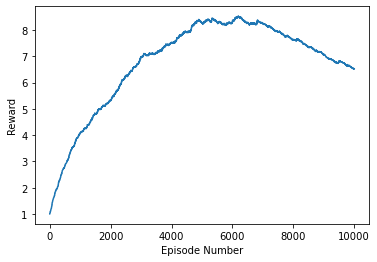

In [20]:
alpha = 0.0005
ema_r = np.zeros_like(N_moves_save)  # Initialize an array for EMA values
ema_r[0] = N_moves_save[0]  # Set the initial EMA value equal to the first data point
for i in range(1, len(N_moves_save)):
    ema_r[i] = alpha * N_moves_save[i] + (1 - alpha) * ema_r[i-1]

fig=plt.subplots(1,1)
plt.plot(np.sum(ema_r,1))
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()

In [21]:
# INITIALISE THE PARAMETERS OF YOUR NEURAL NETWORK AND...
# PLEASE CONSIDER TO USE A MASK OF ONE FOR THE ACTION MADE AND ZERO OTHERWISE IF YOU ARE NOT USING VANILLA GRADIENT DESCENT...
# WE SUGGEST A NETWORK WITH ONE HIDDEN LAYER WITH SIZE 200. 

S, X, W1,W2,bias_W1,bias_W2=Init_network()

# HYPERPARAMETERS SUGGESTED (FOR A GRID SIZE OF 4)

epsilon_0 = 0.2     # STARTING VALUE OF EPSILON FOR THE EPSILON-GREEDY POLICY
beta = 0.00005      # THE PARAMETER SETS HOW QUICKLY THE VALUE OF EPSILON IS DECAYING (SEE epsilon_f BELOW)
gamma = 0.85        # THE DISCOUNT FACTOR
eta = 0.0035        # THE LEARNING RATE

N_episodes = 10000 # THE NUMBER OF GAMES TO BE PLAYED 
# s
# SAVING VARIABLES
R_save_q = np.zeros([N_episodes, 1])
N_moves_save_q = np.zeros([N_episodes, 1])


In [22]:
q_learning = True


for n in range(N_episodes):

    epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
    Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
    i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
    
    S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
    print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
    
    while Done==0:                           ## START THE EPISODE
        
        
        ## THIS IS A RANDOM AGENT, CHANGE IT...
        
        h1, x1, h2, q_values = forward_prop(X, W1, W2, bias_W1, bias_W2)
        
        a_agent= EpsilonGreedy_Policy(q_values, epsilon_f, allowed_a)
        
        
                
        S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)



        
        ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
        if Done==1:
            
            # write the weight updates for the last step of the episode
            
            target_q_values = q_values.copy()
            target_q_values[a_agent] = R 
            e_n = target_q_values - q_values
            dW2 = np.outer(e_n, x1)
            dbias_W2 = e_n
            dh = np.dot(W2.T, e_n)
            dh[h1 <= 0] = 0
            dW1 = np.outer(dh, X)
            dbias_W1 = dh
            


            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2

            R_save_q[n]=np.copy(R)
            N_moves_save_q[n]=np.copy(i)
            break
        
        
        
        
        # IF THE EPISODE IS NOT OVER...
        else:
            
            h1_next, x1_next, h2_next, q_values1 = forward_prop(X_next, W1, W2, bias_W1, bias_W2)
            if q_learning == True:
                # Q learning "greedy" policy
                a_agent1 = EpsilonGreedy_Policy(q_values1, 0, allowed_a)
            else:
                # SARSA policy
                a_agent1 = EpsilonGreedy_Policy(q_values1, epsilon_f, allowed_a)

            target_q_values = q_values.copy()
            target_q_values[a_agent] = R + gamma*q_values1[a_agent1]
            e_n = target_q_values - q_values
            
            dW2 = np.outer(e_n, x1)
            dbias_W2 = e_n
            dh = np.dot(W2.T, e_n)
            dh[h1 <= 0] = 0
            dW1 = np.outer(dh, X)
            dbias_W1 = dh
            
            W2 += eta*dW2
            W1 += eta*dW1

            bias_W1 += eta*dbias_W1
            bias_W2 += eta*dbias_W2

            
        # NEXT STATE AND CO. BECOME ACTUAL STATE...     
            S=np.copy(S_next)
            X=np.copy(X_next)
            allowed_a=np.copy(allowed_a_next)
            
            i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS

        
print(' Average reward:',np.mean(R_save_q),'Number of steps: ',np.mean(N_moves_save_q))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

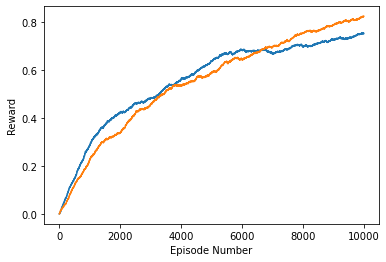

In [29]:
alpha = 0.001
ema_q = np.zeros_like(R_save_q)  # Initialize an array for EMA values
ema_q[0] = R_save_q[0]  # Set the initial EMA value equal to the first data point
for i in range(1, len(R_save_q)):
    ema_q[i] = alpha * R_save_q[i] + (1 - alpha) * ema_q[i-1]

fig=plt.subplots(1,1)
plt.plot(np.sum(ema_q,1))
plt.plot(np.sum(ema,1))
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()

In [49]:
def plot_reward(rewards, alpha):
    ema = np.zeros_like(rewards)  # Initialize an array for EMA values
    ema[0] = rewards[0]  # Set the initial EMA value equal to the first data point
    for i in range(1, len(rewards)):
        ema[i] = alpha * rewards[i] + (1 - alpha) * ema[i-1]

    fig=plt.subplots(1,1)
    plt.plot(np.sum(ema,1))
    
    plt.xlabel('Episode Number')
    plt.ylabel('Reward')
    plt.show()

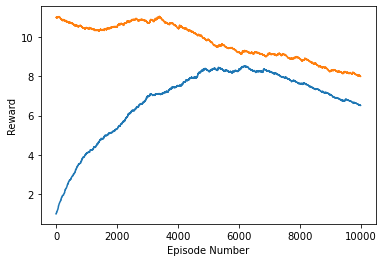

In [28]:
alpha = 0.0005
ema_qr = np.zeros_like(N_moves_save_q)  # Initialize an array for EMA values
ema_qr[0] = N_moves_save_q[0]  # Set the initial EMA value equal to the first data point
for i in range(1, len(N_moves_save_q)):
    ema_qr[i] = alpha * N_moves_save_q[i] + (1 - alpha) * ema_qr[i-1]

fig=plt.subplots(1,1)
plt.plot(np.sum(ema_r,1))
plt.plot(np.sum(ema_qr,1))

plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()

In [50]:
def training_loop(q_learning, N_episodes, epsilon_0, beta, gamma, eta):
    R_save = np.zeros([N_episodes, 1])
    N_moves_save = np.zeros([N_episodes, 1])

    S, X, W1,W2,bias_W1,bias_W2=Init_network()
    for n in range(N_episodes):
        epsilon_f = epsilon_0 / (1 + beta * n)   ## DECAYING EPSILON
        Done=0                                   ## SET DONE TO ZERO (BEGINNING OF THE EPISODE)
        i = 1                                    ## COUNTER FOR NUMBER OF ACTIONS
        
        S,X,allowed_a=env.Initialise_game()      ## INITIALISE GAME
        print(n)                                 ## REMOVE THIS OF COURSE, WE USED THIS TO CHECK THAT IT WAS RUNNING
        
        while Done==0:                           ## START THE EPISODE
            
            
            
            
            h1, x1, h2, q_values = forward_prop(X, W1, W2, bias_W1, bias_W2)
            
            a_agent= EpsilonGreedy_Policy(q_values, epsilon_f, allowed_a)
            
            
                    
            S_next,X_next,allowed_a_next,R,Done=env.OneStep(a_agent)



            
            ## THE EPISODE HAS ENDED, UPDATE...BE CAREFUL, THIS IS THE LAST STEP OF THE EPISODE
            if Done==1:
                
                # write the weight updates for the last step of the episode
                
                target_q_values = q_values.copy()
                target_q_values[a_agent] = R 
                e_n = target_q_values - q_values
                dW2 = np.outer(e_n, x1)
                dbias_W2 = e_n
                dh = np.dot(W2.T, e_n)
                dh[h1 <= 0] = 0
                dW1 = np.outer(dh, X)
                dbias_W1 = dh
                


                W2 += eta*dW2
                W1 += eta*dW1

                bias_W1 += eta*dbias_W1
                bias_W2 += eta*dbias_W2

                R_save[n]=np.copy(R)
                N_moves_save[n]=np.copy(i)
                break
            
            
            
            
            # IF THE EPISODE IS NOT OVER...
            else:
                
                h1_next, x1_next, h2_next, q_values1 = forward_prop(X_next, W1, W2, bias_W1, bias_W2)
                if q_learning == True:
                    # Q learning "greedy" policy
                    a_agent1 = EpsilonGreedy_Policy(q_values1, 0, allowed_a)
                else:
                    # SARSA policy
                    a_agent1 = EpsilonGreedy_Policy(q_values1, epsilon_f, allowed_a)

                target_q_values = q_values.copy()
                target_q_values[a_agent] = R + gamma*q_values1[a_agent1]
                e_n = target_q_values - q_values
                
                dW2 = np.outer(e_n, x1)
                dbias_W2 = e_n
                dh = np.dot(W2.T, e_n)
                dh[h1 <= 0] = 0
                dW1 = np.outer(dh, X)
                dbias_W1 = dh
                
                W2 += eta*dW2
                W1 += eta*dW1

                bias_W1 += eta*dbias_W1
                bias_W2 += eta*dbias_W2

                
            # NEXT STATE AND CO. BECOME ACTUAL STATE...     
                S=np.copy(S_next)
                X=np.copy(X_next)
                allowed_a=np.copy(allowed_a_next)
                
                i += 1  # UPDATE COUNTER FOR NUMBER OF ACTIONS
    
    print(' Average reward:',np.mean(R_save),'Number of steps: ',np.mean(N_moves_save))
    return R_save, N_moves_save

In [66]:
# rewards, steps = training_loop(True, 5000, epsilon_0=.2, beta=0.00005, gamma=0.85, eta=0.0035)
# print(len(rewards))
# plot_reward(rewards, 0.0005)
runs = []
betas = [0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005]
for beta_ in betas:
    rewards, steps = training_loop(True, 10000, epsilon_0=0.2, beta=beta_, gamma=0.85, eta=0.0035)
    run = [rewards, steps]
    runs.append(run)




0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

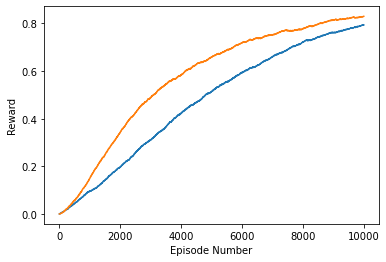

In [67]:
fig = plt.subplots(1,1)

for run in runs:
    rewards = run[0]
    steps = run[1]
    alpha = 0.0005
    ema_r = np.zeros_like(rewards)  # Initialize an array for EMA values
    ema_r[0] = rewards[0]  # Set the initial EMA value equal to the first data point
    for i in range(1, len(rewards)):
        ema_r[i] = alpha * rewards[i] + (1 - alpha) * ema_r[i-1]

    plt.plot(np.sum(ema_r,1))
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()


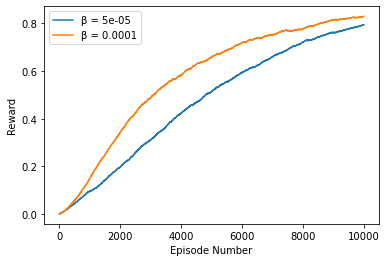

In [68]:
fig, ax = plt.subplots(1, 1)
count = 0
for run in runs:
    rewards = run[0]
    steps = run[1]
    alpha = 0.0005
    ema_r = np.zeros_like(rewards)  # Initialize an array for EMA values
    ema_r[0] = rewards[0]  # Set the initial EMA value equal to the first data point
    for i in range(1, len(rewards)):
        ema_r[i] = alpha * rewards[i] + (1 - alpha) * ema_r[i - 1]
    beta = betas[count]
    ax.plot(np.sum(ema_r, 1), label='β = ' + str(beta))
    count += 1
ax.set_xlabel('Episode Number')
ax.set_ylabel('Average Reward')
ax.legend()
plt.show()

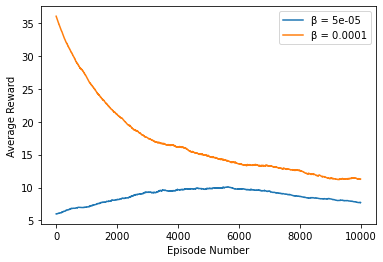

In [69]:
fig, ax = plt.subplots(1, 1)
count = 0
for run in runs:
    rewards = run[0]
    steps = run[1]
    alpha = 0.0005
    ema_r = np.zeros_like(steps)  # Initialize an array for EMA values
    ema_r[0] = steps[0]  # Set the initial EMA value equal to the first data point
    for i in range(1, len(steps)):
        ema_r[i] = alpha * steps[i] + (1 - alpha) * ema_r[i - 1]
    beta = betas[count]
    ax.plot(np.sum(ema_r, 1), label='β = ' + str(beta))
    count += 1
ax.set_xlabel('Episode Number')
ax.set_ylabel('Average Reward')
ax.legend()
plt.show()

In [70]:
gammas = [0.75, 0.85, 0.95]
runs = []   
for gamma_ in gammas:
    rewards, steps = training_loop(True, 10000, epsilon_0=0.2, beta=0.00005, gamma=gamma_, eta=0.0035)
    run = [rewards, steps]
    runs.append(run)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

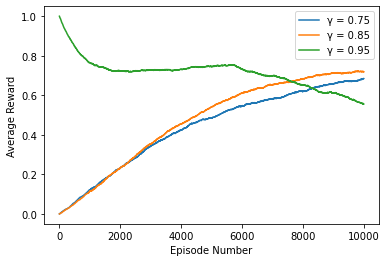

In [72]:
fig, ax = plt.subplots(1, 1)
count = 0
for run in runs:
    rewards = run[0]
    steps = run[1]
    alpha = 0.0005
    ema_r = np.zeros_like(rewards)  # Initialize an array for EMA values
    ema_r[0] = rewards[0]  # Set the initial EMA value equal to the first data point
    for i in range(1, len(rewards)):
        ema_r[i] = alpha * rewards[i] + (1 - alpha) * ema_r[i - 1]
    gamma = gammas[count]
    ax.plot(np.sum(ema_r, 1), label='γ = ' + str(gamma))
    count += 1
ax.set_xlabel('Episode Number')
ax.set_ylabel('Average Reward')
ax.legend()
plt.show()